## Dependencies

In [55]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

In [56]:
# Python SQL toolkit and ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.types import Integer, Text, String, DateTime, Float
import psycopg2

In [106]:
# Store tax revenue csv into a dataframe
tax_revenue_file = "./Data/Cannabis_Tax_Revenue_Growth.csv"
tax_revenue_df = pd.read_csv(tax_revenue_file)

# Set index
# tax_revenue_df.set_index("state", inplace=True)
tax_revenue_df = tax_revenue_df.sort_values('revenue_2019')

In [105]:
# Store drug death csv into a dataframe
drug_death_file = "./Data/Drug_Death_Report_kaggle.csv"
drug_death_df = pd.read_csv(drug_death_file)

# Filtered dataframe
drug_death_cols = ["state", "year", "drug_deaths", "population"]
deaths_transformed = drug_death_df[drug_death_cols].copy()

In [104]:
# Store state legal status csv into a dataframe
state_status_file = "./Data/states_statuses_dolthub.csv"
state_status_df = pd.read_csv(state_status_file)

# Filtered dataframe
state_status_cols = ["state", "medical", "recreational", "illegal"]
state_status_transformed = state_status_df[state_status_cols].copy()

In [101]:
# Store state recreational use of cannabis csv into a dataframe
st_rec_use_file = "./Data/State_Rec_Use_Of_Cannabis_NIH_1.csv"
st_rec_use_df = pd.read_csv(st_rec_use_file)

# Filtered dataframe
st_rec_use_cols = ["jurisdiction", "date_begin", "date_end",
                   "recreational_use_legalized"]
st_rec_use_transformed = st_rec_use_df[st_rec_use_cols].copy()

# Drop nan and set index
# st_rec_use_transformed = st_rec_use_transformed.dropna()
# st_rec_use_transformed = st_rec_use_transformed.set_index("jurisdiction")

st_rec_use_transformed['date_begin'] = st_rec_use_transformed['date_begin'].fillna('01/01/2011')
st_rec_use_transformed['recreational_use_legalized'] = st_rec_use_transformed['recreational_use_legalized'].fillna('No')
st_rec_use_transformed['date_begin'] = pd.to_datetime(st_rec_use_transformed['date_begin'])
st_rec_use_transformed['date_end'] = pd.to_datetime(st_rec_use_transformed['date_end'])

In [103]:
# Database Connection
connection_string = "postgres:postgres@localhost:5432/etl_project"
engine = create_engine(f'postgresql://{connection_string}')

In [62]:
# Confirm tables
engine.table_names()

['state_deaths', 'tax_revenue', 'state_status', 'rec_use']

In [63]:
tax_revenue_df.to_sql(
                name="tax_revenue",
                con=engine,
                if_exists='replace',
                index=False,
                dtype={"state": String,
                       "2018_revenue": Float,
                       "2018_revenue_share": Float,
                       "revenue_2019": Float,
                       "2019_revenue_share": Float,
                       "rev_growth_18_19": Float,
                       "usa_growth_share": Float
                        }
)

In [64]:
deaths_transformed.to_sql(
                name="state_deaths",
                con=engine,
                if_exists='replace',
                index=False,
                dtype={"state": Text,
                       "year": Integer,
                       "drug_deaths": Integer,
                       "population": Integer,
                }
)

In [65]:
state_status_df.to_sql(
                name="state_status",
                con=engine,
                if_exists='replace',
                index=False,
                dtype={"state": Text,
                       "medical": Text,
                       "recreational": Text,
                       "illegal": Text,
                }
)

In [66]:
st_rec_use_transformed.to_sql(
                name="rec_use",
                con=engine,
                if_exists='replace',
                index=False,
                dtype={"jurisdiction": Text,
                       "date_begin": DateTime,
                       "date_end": DateTime,
                       "recreational_use_legalized": Text, 
                       "tax_imposed": Text
                }
)

In [102]:
grouped_st_rec = st_rec_use_transformed.sort_values(['jurisdiction','date_begin'])
# grouped_st_rec.head()

In [68]:
# Count legal states by years
years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
counts = []

for year in years:
    date_year = f"{year}-01-01"
    year_df = grouped_st_rec[(date_year >= grouped_st_rec['date_begin']) 
                             & (date_year <= grouped_st_rec['date_end']) 
                             & (grouped_st_rec['recreational_use_legalized'] == 'Yes')]
    counts.append(year_df['jurisdiction'].count())

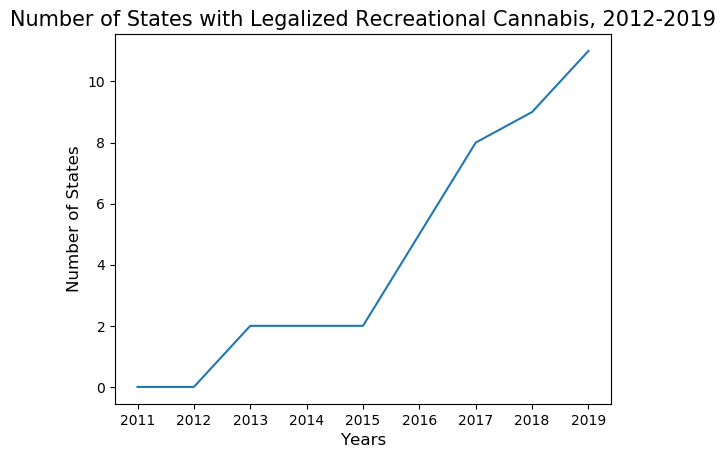

In [74]:
plt.xlabel("Years", size=12)
plt.ylabel("Number of States", size= 12)
plt.title(f"Number of States with Legalized Recreational Cannabis, 2012-2019", size=15)
plt.plot(years, counts)
plt.show()

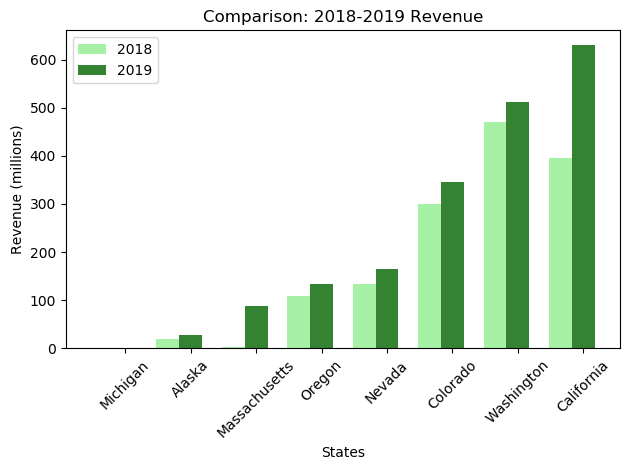

In [100]:
# Plot 2018-2019 Tax Revenue

# data to plot
n_groups = tax_revenue_df['state'].count()
revs_18 = tax_revenue_df['2018_revenue']
revs_19 = tax_revenue_df['revenue_2019']

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, revs_18, bar_width,
alpha=opacity,
color='lightgreen',
label='2018')

rects2 = plt.bar(index + bar_width, revs_19, bar_width,
alpha=opacity,
color='darkgreen',
label='2019')

plt.xlabel('States')
plt.ylabel('Revenue (millions)')
plt.title('Comparison: 2018-2019 Revenue')
plt.xticks(index + bar_width, tax_revenue_df['state'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Plot Drug Deaths
deaths_transformed